In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from math import pi
# qiskit
from qiskit import (
    IBMQ, execute, transpile,
    QuantumRegister, ClassicalRegister, QuantumCircuit,
)
# qurry
sys.path.insert(0, '/home/nccu/文件/.homejupyter/QC_atNCTS')
from qurry.qurry.case.qurecipe import sshxy, trivialParamagnet
from qurry.qurry.mori import Q, keyTupleLoads
from qurry.qurry import EntropyMeasure, backendWrapper
print("Modules import completed...")
print("-"*30+"\n ### Init IBMQ and Set up provider")
IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider(
    hub='ibm-q-hub-ntu', group='ntu-internal', project='default')
bWrapper = backendWrapper(provider)
print("IBMQ loading completed...")

Modules import completed...
------------------------------
 ### Init IBMQ and Set up provider
IBMQ loading completed...


In [11]:
nqubits = 4**2
seed = True
shots = 1024

The minimum value of the Hamiltonian: -230.0620379453393 the configuration: 1111111111111111


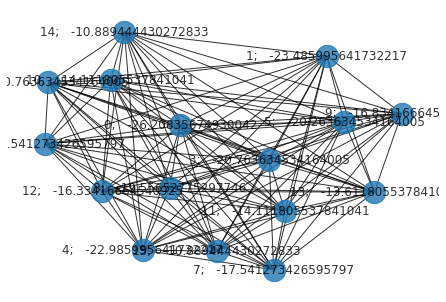

In [3]:
import networkx as nx
from itertools import combinations


def tsp_matrix_to_QUBO_matrix(w):
    n = len(w)
    Q = np.zeros((n*n, n*n))
    c = np.ones(n*n)
    A = np.max(w) * 3.85
    c = c * (-4*A)

    # k, l is the index of Q
    # i, j, p, p_ is the index of w
    for k in range(n*n):
        for l in range(n*n):
            i = k // n
            j = l // n
            p = k % n 
            p_ = l % n 
            if  (p+1)%n == p_:
                Q[k, l] = w[i, j] 
            elif p == p_ and i != j:
                Q[k, l] = Q[k, l] + A
            elif i == j and p != p_:
                Q[k, l] = Q[k, l] + A
            if k > l:
                Q[k, l] = 0

    return Q, c


def QUBO_to_Ising(Q, c):
    J = Q/4
    h = (c - np.sum(Q, axis=1))/2
    for i in range(len(h)):
        J[i][i] = h[i]

    return J


"""
Ising_coeff = [
            [0, 2, 3, 4],
            [0, 0, 8, 1],
            [0, 0, 0, 11],
            [0, 0, 0, 0]
        ]

Ising_coeff = [
            [1, 4],
            [0, 1]
        ]
"""

w = np.array([
      [0, 1, 2**0.5, 1],
      [0, 0, 1, 2**0.5],
      [0, 0, 0, 1],
      [0, 0, 0, 0]     
  ])


Q, c = tsp_matrix_to_QUBO_matrix(w)
Ising_coeff = QUBO_to_Ising(Q, c)
Ising_coeff = Ising_coeff.tolist()


# Visualize the connectivity of the Ising model
G = nx.Graph()
pairs = []
for i in range(0, nqubits):
    G.add_node(i, weight = Ising_coeff[i][i])
    for j in range(i+1, nqubits):
        pairs.append((i, j, Ising_coeff[i][j]))
G.add_weighted_edges_from(pairs)
labels = {n: str(n) + ';   ' + str(G.nodes[n]['weight']) for n in G.nodes}
nx.draw(G, with_labels=True, labels=labels, alpha=0.8, node_size=500)


# @jit(nopython=True, parallel=True, fastmath=True)
def H_Ising(bitstring, Ising_coeff):
    spins = []
    for bit in bitstring:
        if bit == '0':
            spins.append(-1)
        elif bit == '1':
            spins.append(1)
    H = 0
    for i in range(0, nqubits):
        H += Ising_coeff[i][i]*spins[i]
        for j in range(i+1, nqubits):
            H += Ising_coeff[i][j]*spins[i]*spins[j]
    return H


H_min = 10000
for i in range(2**len(Ising_coeff)):
    bitstring = np.binary_repr(i, nqubits)
    if H_Ising(bitstring, Ising_coeff) < H_min:
        H_min = H_Ising(bitstring, Ising_coeff)
        config_min = bitstring
print('The minimum value of the Hamiltonian:', H_min, 'the configuration:', config_min)

In [7]:


def compute_expectation(counts, Ising_coeff) -> float:   
    """
    Computes expectation value based on measurement results
    """   
    sum = 0
    sum_count = 0
    for bitstring, count in counts.items():
        sum += count*H_Ising(bitstring, Ising_coeff)
        sum_count += count
    return sum/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(Ising_coeff, theta): 
    """
    Creates a parametrized qaoa circuit
    """   
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for i in range(nqubits):
            for j in range(i+1, nqubits):
                if Ising_coeff != 0:
                    qc.rzz(2 * Ising_coeff[i][j]*gamma[irep], i, j)
        # mixer unitary
        for i in range(nqubits):
            qc.rz(2 * Ising_coeff[i][i]*gamma[irep], i)
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(theta: list[float]):
    """
    Runs parametrized circuit and get expectation value
    
    """
    b = bWrapper('aer_gpu')
    qc = create_qaoa_circ(Ising_coeff, theta)       
    qc = transpile(qc, backend=b)
    if seed:
        seed_simulator = 10
    else:
        seed_simulator = None
    counts: dict[str, int] = b.run(qc, seed_simulator=seed_simulator, nshots=shots).result().get_counts()       

    return compute_expectation(counts, Ising_coeff)

In [39]:
from scipy.optimize import minimize

res = minimize(get_expectation, [1.0, 1.0, 1, 0,2, 1, 0], method='COBYLA')
res

     fun: -93.59179250954689
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 83
  status: 1
 success: True
       x: array([ 0.86043345,  1.68284809,  1.45058651, -0.13531172,  1.97980397,
        2.06010752,  0.06058464])

In [152]:
circuit = create_qaoa_circ(Ising_coeff, [1, 1])
circuit = transpile(circuit, backend=backend('auckland'))
circuit.draw()

global phase: 3.1496
         ┌───┐                                                       »
    q_0: ┤ H ├─■───────■────────────────────■────────────────────────»
         ├───┤ │ZZ(0)  │                    │                        »
    q_1: ┤ H ├─■───────┼────────────■───────┼────────────■───────────»
         ├───┤         │ZZ(2.7224)  │ZZ(0)  │            │           »
    q_2: ┤ H ├─────────■────────────■───────┼────────────┼───────────»
         ├───┤                              │ZZ(2.7224)  │ZZ(2.7224) »
    q_3: ┤ H ├──────────────────────────────■────────────■───────────»
         ├───┤                                                       »
    q_4: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
    q_5: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
    q_6: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
    q_7: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
    q_8: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
    q_9: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
   q_10: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
   q_11: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
   q_12: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
   q_13: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
   q_14: ┤ H ├───────────────────────────────────────────────────────»
         ├───┤                                                       »
   q_15: ┤ H ├───────────────────────────────────────────────────────»
         └───┘                                                       »
meas: 16/════════════════════════════════════════════════════════════»
                                                                     »
«                                                                             »
«    q_0: ─■────────────────────────────■──────────────────────────────■──────»
«          │                            │                              │      »
«    q_1: ─┼────────────────────■───────┼─────────────────■────────────┼──────»
«          │                    │       │                 │            │      »
«    q_2: ─┼────────────■───────┼───────┼─────────■───────┼────────────┼──────»
«          │            │ZZ(0)  │       │         │       │            │      »
«    q_3: ─┼────────────■───────┼───────┼─────────┼───────┼────────────┼──────»
«          │ZZ(2.7224)          │ZZ(0)  │         │ZZ(0)  │            │      »
«    q_4: ─■────────────────────■───────┼─────────■───────┼────────────┼──────»
«                                       │ZZ(0.5)          │ZZ(2.7224)  │      »
«    q_5: ──────────────────────────────■─────────────────■────────────┼──────»
«                                                                      │ZZ(0) »
«    q_6: ─────────────────────────────────────────────────────────────■──────»
«                                                                             »
«    q_7: ────────────────────────────────────────────────────────────────────»
«                                                                             »
«    q_8: ────────────────────────────────────────────────────────────────────»
«                                                     

In [153]:
def optimizer(eps, theta, lr, momentum):
    grad = [0 for t in range(len(theta))]
    for i in range(len(theta)):
        # Uses a symmetric difference to calulate the gradient
        theta[i] += eps
        grad[i] = get_expectation(theta)
        theta[i] -= 2*eps
        grad[i] -= get_expectation(theta)
        grad[i] /= 2*eps
        theta[i] += eps      
        # Update the parameters by gradient descent with momentum
        v[i] = momentum*v[i] - lr*grad[i]
        theta[i] = theta[i] + v[i]

    return theta

In [154]:
seed = True
shots = 1024
eps = 10**-6
p = 2
lr = 100
momentum = 0.0
num_steps = 30
schedule = [25]
lr_decay = 0.1


# Initialize the parameters
torch.manual_seed(0)
theta = torch.empty(int(2*p))
torch.nn.init.normal_(theta, mean=0.5, std=0.01)
theta = theta.tolist()


expectation_list = []
theta_list = []
# Perform SGD with momentum
v = [0 for i in range(int(2*p))]
for i in range(num_steps + 1):      # Update the parameters
    expectation = get_expectation(theta)
    expectation_list.append(expectation)
    if i in schedule:      # Learning rate scheduling (step)
        lr = lr*lr_decay
    theta = optimizer(eps, theta, lr, momentum)
    if (i != 0) and (i % 10 == 0):
        theta_list.append(theta)
    print('The expectation values at iteration =', i, 'is:', expectation)

The expectation values at iteration = 0 is: -4.547969447179736
The expectation values at iteration = 1 is: -2.966366565478261
The expectation values at iteration = 2 is: 2.185506721157408
The expectation values at iteration = 3 is: -0.954986054978851
The expectation values at iteration = 4 is: -1.0107170287232004


KeyboardInterrupt: ignored

In [ ]:
"""
seed = True
shots = 1024
eps = 10**-3
momentum = 0.0
num_steps = 100
schedule = [60]
lr_decay = 0.1

p_list = [int(i+1) for i in range(10)]
lr_list = [0.5*10**-2, 1*10**-2, 2*10**-2, 5*10**-2, 10*10**-2, 20*10**-2, 50*10**-2]

p_list = [2]
lr_list = [0.01]


minimum_list = []
lr_best_list = []
theta_best_list = []
for num_p in p_list:
    p = num_p
    print('\nFor p =', p, ':')
    minimum = 1
    for lr in lr_list:
        # Initialize the parameters
        torch.manual_seed(0)
        theta = torch.empty(1, int(2*p))
        torch.nn.init.normal_(theta, mean=0.5, std=0.01)
        theta = theta.tolist()[0]
        # Perform SGD with momentum
        v = [0 for i in range(len(theta))]
        for i in range(num_steps + 1):      # Update the parameters
            if i in schedule:      # Learning rate scheduling (step)
                lr = lr*lr_decay
            theta = optimizer(eps, theta, lr, momentum)

        expectation = get_expectation(theta)
        if expectation < minimum:
            minimum = expectation
            lr_best = lr
            theta_best = theta

        print('Learning rate =', lr, 'the expectation value =', expectation)

    minimum_list.append(minimum)
    lr_best_list.append(lr_best)
    theta_best_list.append(theta_best)
    print('The min. expectation value = ', minimum, 'when learning rate =', lr_best)
    print('-----------------Temporary results-----------------')
    for i in range(len(minimum_list)): 
        print('The optimized parameters:',  theta_best_list[i])
    print('Min. expectaion value =', minimum_list)
    print('Best learning rate =', lr_best_list)
"""

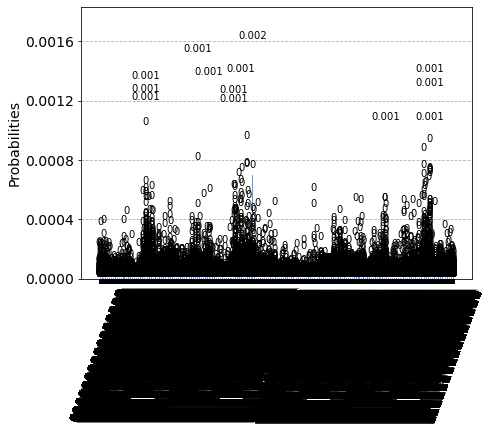

In [18]:
from qiskit.visualization import plot_histogram

qc_result = create_qaoa_circ(Ising_coeff, [1.0, 1.0])
counts = bWrapper('aer_gpu').run(qc_result, shots=2**20).result().get_counts()

plot_histogram(counts)

In [35]:
def maxCounts(_counts: dict[str, int]) -> str:
    vs = list(_counts.values())
    vsMax = max(_counts.values())
    vsMaxIndex = list(_counts.keys())[vs.index(vsMax)]
    return vsMaxIndex


In [34]:
vsMaxIndex

'0110111010101010'

In [32]:
counts['0110111010101010']

1601

In [31]:
list(counts.keys())[vs.index(1601)]

'0110111010101010'

In [20]:
counts['1111111111111111']

22

In [26]:
1601/2**20

0.0015268325805664062